In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygad

import itertools
import random

from graph import Graph

### Construct graph

Constructs a random graph with a given number of vertices

In [75]:
vs = 20
edges = []
for v1, v2 in itertools.product(range(vs), repeat=2):
    if v1 == v2:
        continue
    if random.random() < 0.2:
        edges.append((v1, v2))

# edges = [(0,1), (0,2), (0,3), (1,2), (1,3), (2, 3)]

print(f"|Edges| = {len(edges)}")
g = Graph(vs, edges)

# g.get_dot()

|Edges| = 87


In [76]:
from functools import partial, reduce

def edge_eq(e1, e2):
    return (e1[0] == e2[0] and e1[1] == e2[1]) or (e1[0] == e2[1] and e1[1] == e2[0])

def edge_in(e, edges):
    return reduce(lambda x, y : x or y, map(partial(edge_eq, e), edges), False)

def get_conflicted_pairs(g : Graph):
    conflict_pairs = []
    for v1, v2 in g.get_adjacent_vertices():
        # print(f"DEBUG: {g.get_colors()}")
        # print(f"DEBUG: ({v1}, {v2})")
        # print(f"DEBUG: {g.get_color(v1)}")
        if g.get_color(v1) == g.get_color(v2):
            if not edge_in((v1, v2), conflict_pairs):
                conflict_pairs.append((v1, v2))

    return conflict_pairs

def get_vertices_in_conflict(g : Graph):
    conflicts = []
    for v1, v2 in g.get_adjacent_vertices():
        if g.get_color(v1) == g.get_color(v2):
            if v1 not in conflicts:
                conflicts.append(v1)
            if v2 not in conflicts:
                conflicts.append(v2)
    return conflicts

# get_conflicted_pairs(g)

# Fitness function

The genome of a graph represents the coloring of vertices

The fitness function takes a genome, and counts the number of adjacent vertices that have the same color. The fitness is the reciprocal of this value (plus one, to avoid division by zero).

In [77]:
def fitness_func(solution, solution_idx):
    #update graph
    g = Graph(vs, edges)
    g.set_colors(solution)

    # compute the number of ajacent vertices that share a color
    incorrect_verteces = 0
    for v1, v2 in g.get_adjacent_vertices():
        if g.get_color(v1) == g.get_color(v2):
            incorrect_verteces += 1

    return 1.0 / (incorrect_verteces + 1)

def conflicts(solution):
    # Calculating the fitness value of each solution in the current population.
    # output = np.sum(solution*function_inputs)
    # fitness = 1.0 / numpy.abs(output - desired_output)

    #update graph
    g = Graph(vs, edges)
    g.set_colors(solution)

    # compute the number of ajacent vertices that share a color
    incorrect_verteces = 0
    for v1, v2 in g.get_adjacent_vertices():
        if g.get_color(v1) == g.get_color(v2):
            incorrect_verteces += 1

    return incorrect_verteces / 2 

# Crossover

In [78]:
def crossover_func(parents, offspring_size, ga_instance):
    # print(f"{parents.shape=}")
    # print(f"{parents=}")
    # print(f"{offspring_size=}")
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()

        # random_split_point = np.random.choice(range(offspring_size[0]))
        g = Graph(vs, edges)
        g.set_colors(parent1)
        conflicts = get_vertices_in_conflict(g)
        # print(conflicts)

        parent1[conflicts] = parent2[conflicts]

        offspring.append(parent1)

        idx += 1
    
    return np.array(offspring)

# Mutation

In [79]:
mutation_prob = 0.2
def mutation_func(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        # find vertices that are in conflict
        g = Graph(vs, edges)
        g.set_colors(offspring[chromosome_idx, :])

        conflicts = get_conflicted_pairs(g)

        #change one vertex from each conflict with mutation probabily
        for v1, _ in conflicts:
            if random.random() < ga_instance.mutation_probability:
                offspring[chromosome_idx, v1] = random.choice(ga_instance.gene_space)
    
    return offspring

In [80]:
fitness_function = fitness_func

num_generations = 100 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.

# To prepare the initial population, there are 2 ways:
# 1) Prepare it yourself and pass it to the initial_population parameter. This way is useful when the user wants to start the genetic algorithm with a custom initial population.
# 2) Assign valid integer values to the sol_per_pop and num_genes parameters. If the initial_population parameter exists, then the sol_per_pop and num_genes parameters are useless.
sol_per_pop = 50 # Number of solutions in the population.
num_genes = g.num_vertices

last_fitness = 0
def callback_generation(ga_instance):
    global last_fitness
    change = ga_instance.best_solution()[1] - last_fitness
    # print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    if change > 0:
        print("Generation = {generation}".format(generation=ga_instance.generations_completed))
        print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
        print("Change     = {change}".format(change=change))
    last_fitness = ga_instance.best_solution()[1]

def callback_stop(ga_instance, fitnesses):
    global last_fitness
    last_fitness = 0

# Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.
ga_args = {
    "num_generations":num_generations,
    "num_parents_mating":num_parents_mating, 
    "fitness_func":fitness_function,
    "crossover_type":crossover_func,
    "mutation_type":mutation_func,
    "mutation_probability":0.4,
    "sol_per_pop":sol_per_pop, 
    "num_genes":num_genes,
    "gene_type":int,
    "gene_space":range(0, 5),
    "on_generation":callback_generation,
    "on_stop":callback_stop,
    "stop_criteria":["reach_1"]
}
# ga_instance = pygad.GA(num_generations=num_generations,
#                        num_parents_mating=num_parents_mating, 
#                        fitness_func=fitness_function,
#                        crossover_type=crossover_func,
#                        mutation_type=mutation_func,
#                        mutation_probability=0.2,
#                        sol_per_pop=sol_per_pop, 
#                        num_genes=num_genes,
#                        gene_type=int,
#                        gene_space=range(0, 5),
#                        on_generation=callback_generation,
#                        stop_criteria=["reach_1"])

# # Running the GA to optimize the parameters of the function.
# ga_instance.run()

# # After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
# ga_instance.plot_fitness()

# solution, solution_fitness, solution_idx = ga_instance.best_solution()
# g.set_colors(solution)
# print("Parameters of the best solution : {solution}".format(solution=solution))
# print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
# print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))
# print(f"Number of conflicts = {conflicts(solution)}")

# g.get_dot()

In [81]:
runs = 100

best_solutions = []
best_solutions_fitnesses = []
fitness_developments_raw = []
best_solution_generations = []

ga_args["on_generation"] = None

import time
for run in range(runs):
    T1 = time.time()
    ga_instance = pygad.GA(**ga_args)
    ga_instance.run()
    T2 = time.time()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    best_solutions.append(solution)
    best_solutions_fitnesses.append(solution_fitness)
    # print(len(ga_instance.best_solutions_fitness))
    # print(ga_instance.best_solutions_fitness)
    fitness_developments_raw.append(ga_instance.best_solutions_fitness)
    best_solution_generations.append(ga_instance.best_solution_generation)

    print(f"{run=} T={T2-T1} | Best Fitness={solution_fitness}")

run=0 T=3.1315865516662598 | Best Fitness=0.2
run=1 T=3.234544277191162 | Best Fitness=0.2
run=2 T=3.772733449935913 | Best Fitness=0.14285714285714285
run=3 T=4.1887617111206055 | Best Fitness=0.2
run=4 T=3.7896406650543213 | Best Fitness=0.3333333333333333
run=5 T=4.195050001144409 | Best Fitness=0.2
run=6 T=4.101709842681885 | Best Fitness=0.2
run=7 T=3.6348769664764404 | Best Fitness=0.3333333333333333
run=8 T=3.7154533863067627 | Best Fitness=0.3333333333333333
run=9 T=3.7310378551483154 | Best Fitness=0.3333333333333333
run=10 T=3.9701695442199707 | Best Fitness=0.3333333333333333
run=11 T=9.469059228897095 | Best Fitness=0.2
run=12 T=5.704541444778442 | Best Fitness=0.2
run=13 T=4.450080871582031 | Best Fitness=0.2
run=14 T=0.28523755073547363 | Best Fitness=1.0
run=15 T=0.25232410430908203 | Best Fitness=1.0
run=16 T=0.16951656341552734 | Best Fitness=1.0
run=17 T=3.615363121032715 | Best Fitness=0.2
run=18 T=3.537494421005249 | Best Fitness=0.3333333333333333
run=19 T=3.851236

In [82]:
# print(best_solution_generations)
# print(best_solutions_fitnesses)
# print([conflicts(solution) for solution in best_solutions])

#pad fitnesses in runs that ended early
from copy import deepcopy
fitness_developments = deepcopy(fitness_developments_raw)
for i, x in enumerate(fitness_developments):
    if (x_len := len(x)) < num_generations + 1:
        # print(f"{i=} {len(x)}")
        # print(f"{i=} {len(x + [x[-1]] * ((num_generations + 1) - x_len))}")
        x = x + [x[-1]] * (num_generations + 1 - x_len)
        fitness_developments[i] = x
# print([len(x) for x in fitness_developments])
df = pd.DataFrame(
    {
        "generation":best_solution_generations,
        "fitness": best_solutions_fitnesses,
        "conflicts": [conflicts(solution) for solution in best_solutions]
    }
)

df["conflict_ratio"] = df["conflicts"] / vs
df["solution_found"] = df["fitness"] == 1
df["solution_not_in_init_pop"] = df["generation"] != 1

Solution found in 11.0% runs
Conflicts: mean=1.41, std=0.7925792188682582, mean ratio to vertices=0.0705
[101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101]


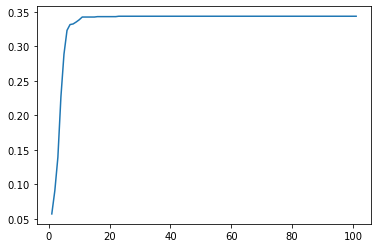

In [83]:

solution_count = df[df["solution_found"]].shape[0]
print(f"Solution found in {solution_count/runs * 100}% runs")
print(f"Conflicts: mean={df['conflicts'].mean()}, std={df['conflicts'].std()}, mean ratio to vertices={df['conflict_ratio'].mean()}")

# Plot fitness
fitness_developments = np.array(fitness_developments)
print([len(x) for x in fitness_developments])
# print(fitness_developments)
_ = plt.plot(range(1, num_generations+1+1), fitness_developments.T.mean(axis=-1))

In [84]:
# Save dataframe and fitness developments
idx = 0.2
df_fout_name = f"res_vs{vs}_edg{len(edges)}_runs{runs}_{idx}.csv"
fit_fout_name = f"fit_vs{vs}_edg{len(edges)}_run_{runs}_{idx}"

import csv
with open(df_fout_name, 'w') as fout:
    df.to_csv(fout)
with open(fit_fout_name, 'w') as fout:
    wr = csv.writer(fout)
    wr.writerows(fitness_developments)